In [246]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
import warnings
warnings.filterwarnings('ignore')

In [343]:
def load():
    data = pd.read_csv("Telco-Customer-Churn.csv")
    return data
tc = load()
df = tc.copy()

In [344]:
#df.columns = [col.upper() for col in df.columns]

In [345]:
#df.columns

**KEŞİFÇİ VERİ ANALİZİ**

**Genel resim.**

In [346]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [347]:
# TotalCharges sayısal bir değişken olmalı
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

In [348]:
df["Churn"] = df["Churn"].apply(lambda x : 1 if x == "Yes" else 0)

In [349]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


**Numerik ve kategorik değişkenler.**

In [350]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [351]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


In [352]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [353]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Churn']

In [354]:
cat_but_car

['customerID']

**Numerik ve kategorik değişkenlerin analizi.**

In [355]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=col_name, data=dataframe)
        plt.show(block=True)
        
    print("****************************************************")

        gender     Ratio
Male      3555  50.47565
Female    3488  49.52435


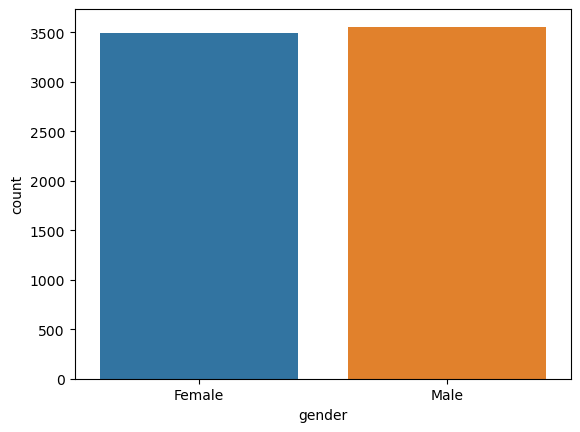

****************************************************
     Partner     Ratio
No      3641  51.69672
Yes     3402  48.30328


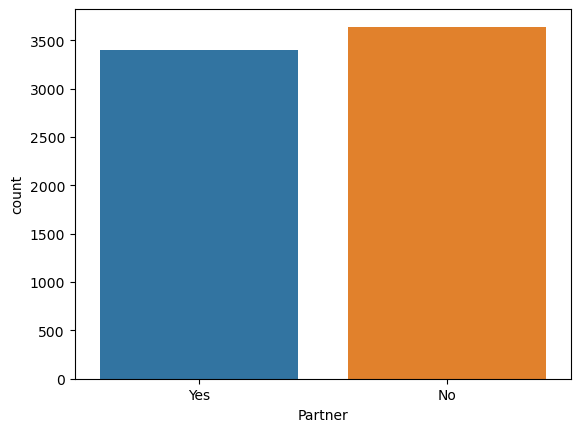

****************************************************
     Dependents      Ratio
No         4933  70.041176
Yes        2110  29.958824


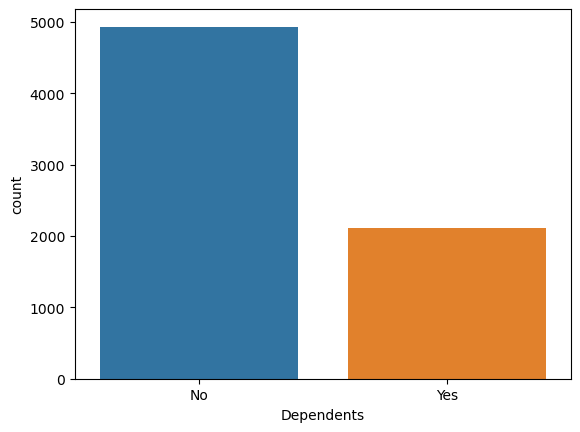

****************************************************
     PhoneService      Ratio
Yes          6361  90.316626
No            682   9.683374


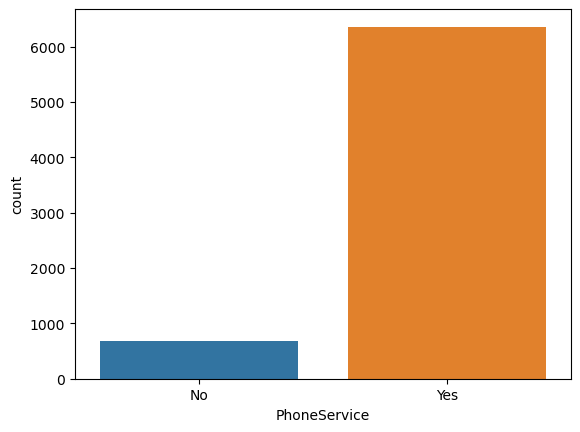

****************************************************
                  MultipleLines      Ratio
No                         3390  48.132898
Yes                        2971  42.183729
No phone service            682   9.683374


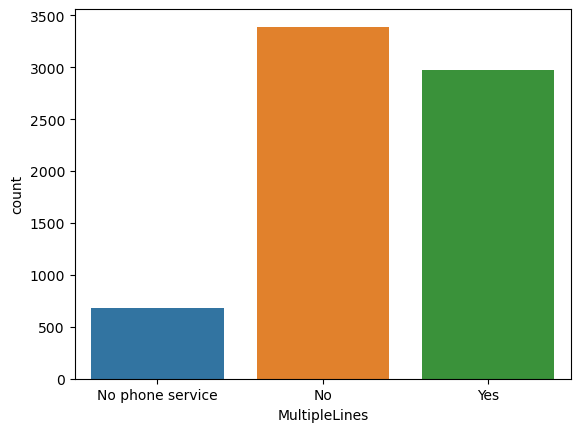

****************************************************
             InternetService      Ratio
Fiber optic             3096  43.958540
DSL                     2421  34.374556
No                      1526  21.666903


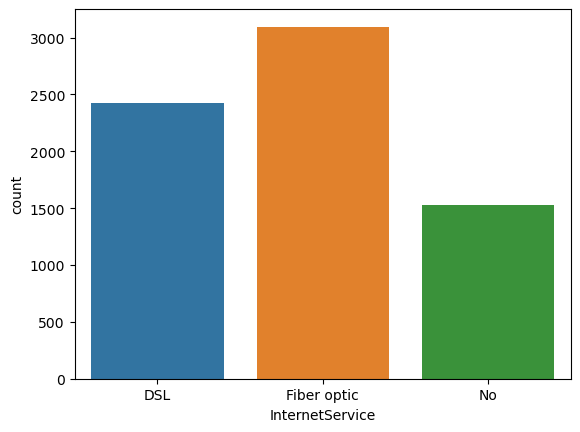

****************************************************
                     OnlineSecurity      Ratio
No                             3498  49.666335
Yes                            2019  28.666761
No internet service            1526  21.666903


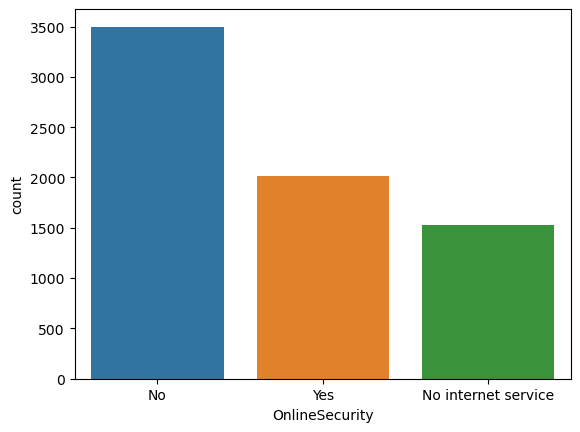

****************************************************
                     OnlineBackup      Ratio
No                           3088  43.844952
Yes                          2429  34.488144
No internet service          1526  21.666903


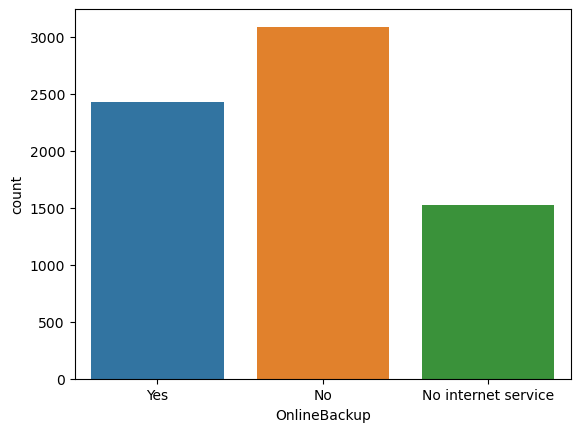

****************************************************
                     DeviceProtection      Ratio
No                               3095  43.944342
Yes                              2422  34.388755
No internet service              1526  21.666903


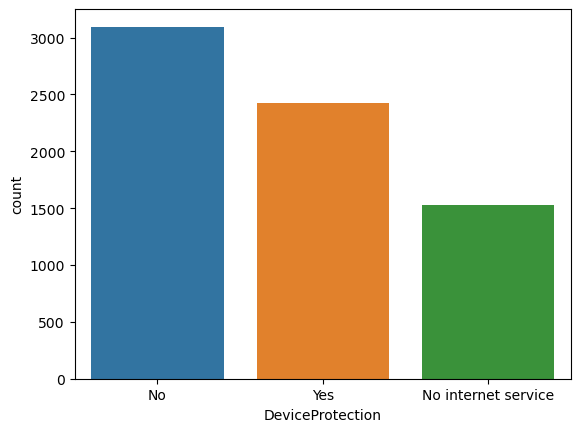

****************************************************
                     TechSupport      Ratio
No                          3473  49.311373
Yes                         2044  29.021724
No internet service         1526  21.666903


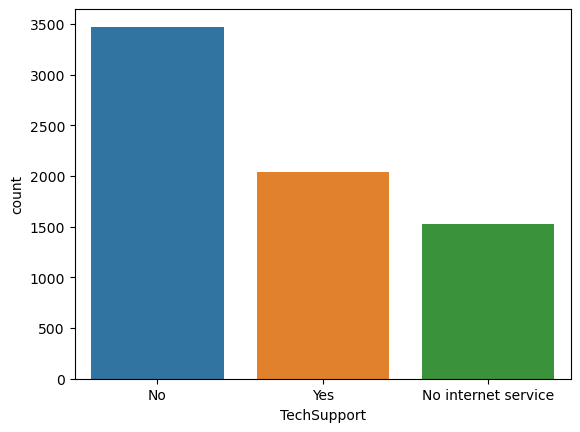

****************************************************
                     StreamingTV      Ratio
No                          2810  39.897771
Yes                         2707  38.435326
No internet service         1526  21.666903


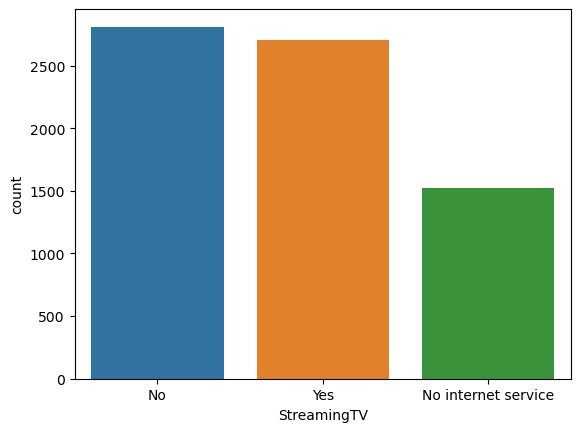

****************************************************
                     StreamingMovies      Ratio
No                              2785  39.542808
Yes                             2732  38.790288
No internet service             1526  21.666903


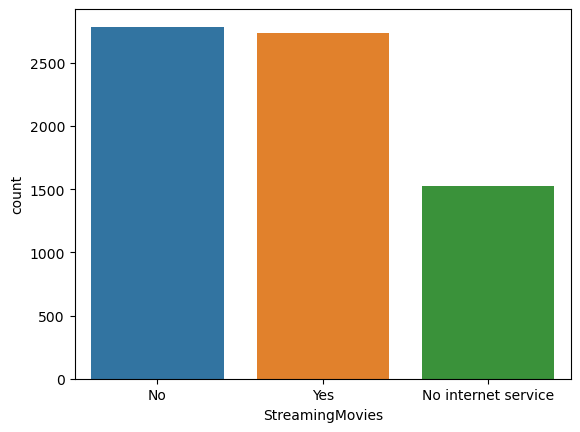

****************************************************
                Contract      Ratio
Month-to-month      3875  55.019168
Two year            1695  24.066449
One year            1473  20.914383


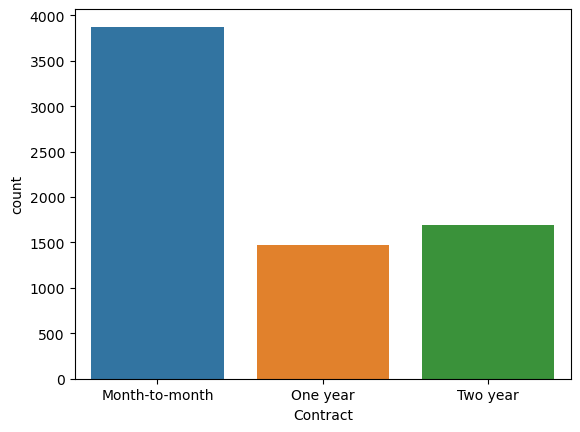

****************************************************
     PaperlessBilling      Ratio
Yes              4171  59.221922
No               2872  40.778078


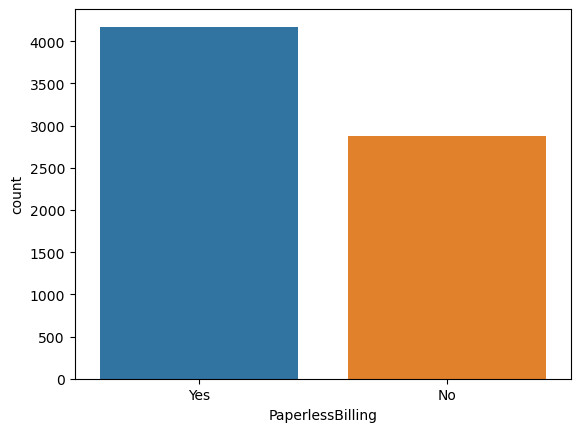

****************************************************
                           PaymentMethod      Ratio
Electronic check                    2365  33.579441
Mailed check                        1612  22.887974
Bank transfer (automatic)           1544  21.922476
Credit card (automatic)             1522  21.610109


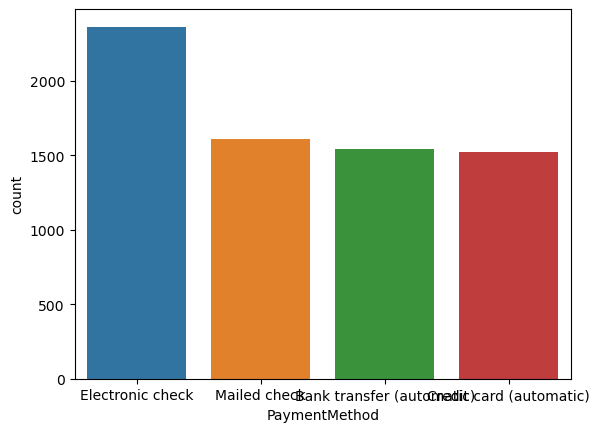

****************************************************
   SeniorCitizen      Ratio
0           5901  83.785319
1           1142  16.214681


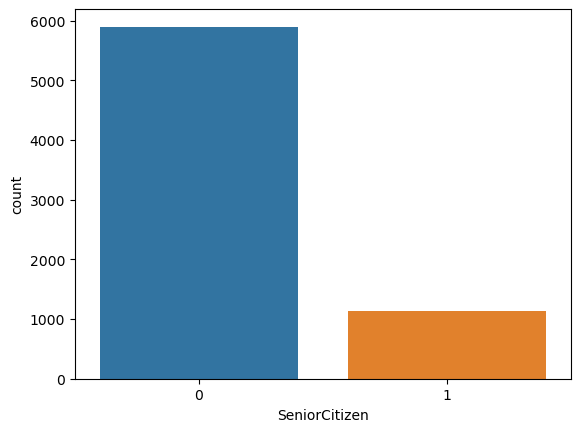

****************************************************
   Churn      Ratio
0   5174  73.463013
1   1869  26.536987


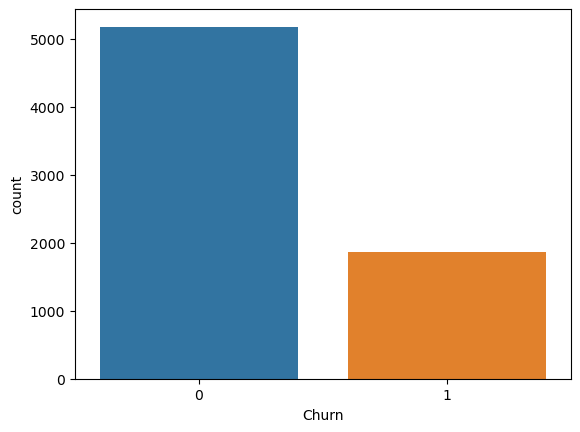

****************************************************


In [356]:
[cat_summary(df,col,plot=True) for col in cat_cols];

In [357]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.01,0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95,0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    
    if plot:
        sns.histplot(dataframe[numerical_col], kde = False);
        plt.show(block=True)
        
    print("#################################")

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
1%          1.000000
5%          1.000000
10%         2.000000
20%         6.000000
30%        12.000000
40%        20.000000
50%        29.000000
60%        40.000000
70%        50.000000
80%        60.000000
90%        69.000000
95%        72.000000
99%        72.000000
max        72.000000
Name: tenure, dtype: float64


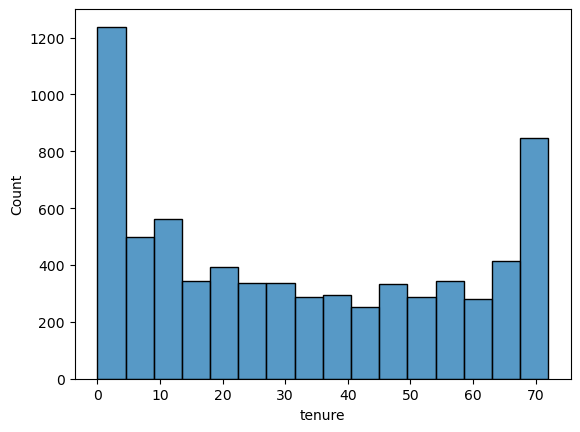

#################################
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
1%         19.200000
5%         19.650000
10%        20.050000
20%        25.050000
30%        45.850000
40%        58.830000
50%        70.350000
60%        79.100000
70%        85.500000
80%        94.250000
90%       102.600000
95%       107.400000
99%       114.729000
max       118.750000
Name: MonthlyCharges, dtype: float64


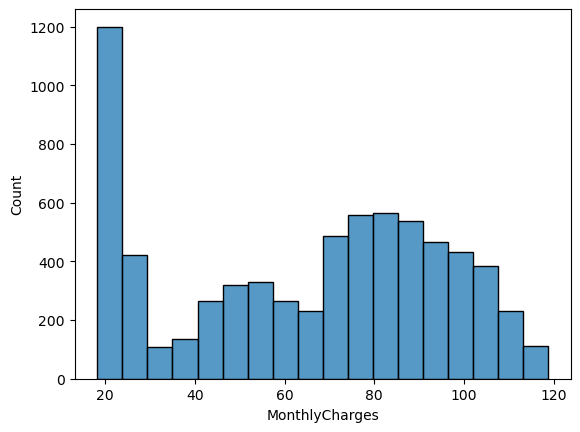

#################################
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
1%         19.900000
5%         49.605000
10%        84.600000
20%       267.070000
30%       551.995000
40%       944.170000
50%      1397.475000
60%      2048.950000
70%      3141.130000
80%      4475.410000
90%      5976.640000
95%      6923.590000
99%      8039.883000
max      8684.800000
Name: TotalCharges, dtype: float64


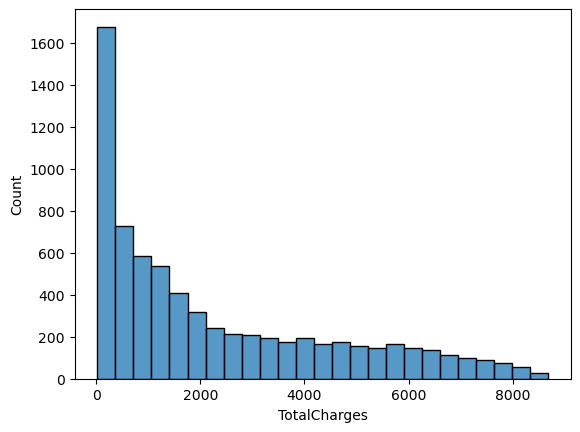

#################################


In [358]:
[num_summary(df,col,plot=True) for col in num_cols];   

**Hedef değişken analizi  (Kategorik değişkenlere göre hedef değişkenin ortalaması, hedef değişkene göre 
numerik değişkenlerin ortalaması)**

In [359]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Churn", col)

          tenure
Churn           
0      37.569965
1      17.979133


       MonthlyCharges
Churn                
0           61.265124
1           74.441332


       TotalCharges
Churn              
0       2555.344141
1       1531.796094




In [360]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

gender
        TARGET_MEAN  Count     Ratio
Female     0.269209   3488  49.52435
Male       0.261603   3555  50.47565


Partner
     TARGET_MEAN  Count     Ratio
No      0.329580   3641  51.69672
Yes     0.196649   3402  48.30328


Dependents
     TARGET_MEAN  Count      Ratio
No      0.312791   4933  70.041176
Yes     0.154502   2110  29.958824


PhoneService
     TARGET_MEAN  Count      Ratio
No      0.249267    682   9.683374
Yes     0.267096   6361  90.316626


MultipleLines
                  TARGET_MEAN  Count      Ratio
No                   0.250442   3390  48.132898
No phone service     0.249267    682   9.683374
Yes                  0.286099   2971  42.183729


InternetService
             TARGET_MEAN  Count      Ratio
DSL             0.189591   2421  34.374556
Fiber optic     0.418928   3096  43.958540
No              0.074050   1526  21.666903


OnlineSecurity
                     TARGET_MEAN  Count      Ratio
No                      0.417667   3498  49.666335
No internet ser

**Korelasyon analizi**

In [361]:
df.corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
SeniorCitizen,1.000000,0.016567,0.220173,0.102411,0.150889
tenure,0.016567,1.000000,0.247900,0.825880,-0.352229
MonthlyCharges,0.220173,0.247900,1.000000,0.651065,0.193356
TotalCharges,0.102411,0.825880,0.651065,1.000000,-0.199484
Churn,0.150889,-0.352229,0.193356,-0.199484,1.000000


In [362]:
# TotalChargers'in aylık ücretler ve tenure ile yüksek korelasyonlu olduğu görülmekte

df.corrwith(df["Churn"]).sort_values(ascending=False)

Churn             1.000000
MonthlyCharges    0.193356
SeniorCitizen     0.150889
TotalCharges     -0.199484
tenure           -0.352229
dtype: float64

**FEATURE ENGINEERING**

**Eksik Değer Analizi**

In [363]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [364]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [365]:
na_columns = missing_values_table(df, na_name=True)

              n_miss  ratio
TotalCharges      11   0.16


In [366]:
df[df["TotalCharges"].isnull()]["tenure"]

488     0
753     0
936     0
1082    0
1340    0
3331    0
3826    0
4380    0
5218    0
6670    0
6754    0
Name: tenure, dtype: int64

In [367]:
df["TotalCharges"].fillna(0, inplace=True)

In [368]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

**Aykırı Değer Analizi**

In [369]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [370]:
# Aykırı Değer Analizi ve Baskılama İşlemi
for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

tenure False
MonthlyCharges False
TotalCharges False


**Özellik Çıkarımı**

In [371]:
# Tenure  değişkeninden yıllık kategorik değişken oluşturma
df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"



# Kişinin toplam aldığı servis sayısı
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)


# Kişi otomatik ödeme yapıyor mu?
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

# ortalama aylık ödeme
df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] + 1)

# Güncel Fiyatın ortalama fiyata göre artışı
df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

# Servis başına ücret
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

In [372]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_TotalServices,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-1 Year,1,0,14.925000,0.500000,14.9250
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,2-3 Year,3,0,53.985714,0.947949,14.2375
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-1 Year,3,0,36.050000,0.669452,13.4625
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3-4 Year,3,1,40.016304,0.946012,10.5750
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0-1 Year,1,0,50.550000,0.714993,35.3500


**Encoding** (kategorikler için)

In [390]:
#makinenin anlaması için encode işlemi yapıyoruz 1 ve 0 dili

In [389]:
#yukarıda yeni değişkenler eklediğimiz için güncelleme yapıyoruz

In [373]:
# Değişkenlerin tiplerine göre ayrılması işlemi
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 27
cat_cols: 20
num_cols: 6
cat_but_car: 1
num_but_cat: 4


In [374]:
# LABEL ENCODING
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [375]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

In [376]:
for col in binary_cols:
    df = label_encoder(df, col)

In [377]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_TotalServices,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,7590-VHVEG,0,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0,0-1 Year,1,0,14.925000,0.500000,14.9250
1,5575-GNVDE,1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0,2-3 Year,3,0,53.985714,0.947949,14.2375
2,3668-QPYBK,1,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1,0-1 Year,3,0,36.050000,0.669452,13.4625
3,7795-CFOCW,1,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0,3-4 Year,3,1,40.016304,0.946012,10.5750
4,9237-HQITU,0,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1,0-1 Year,1,0,50.550000,0.714993,35.3500


In [378]:
# One-Hot Encoding İşlemi
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [379]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'NEW_TENURE_YEAR',
 'NEW_TotalServices']

In [380]:
df = one_hot_encoder(df, ohe_cols, drop_first=True)

In [381]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,NEW_TotalServices_1,NEW_TotalServices_2,NEW_TotalServices_3,NEW_TotalServices_4,NEW_TotalServices_5,NEW_TotalServices_6,NEW_TotalServices_7
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,0,0,14.925000,0.500000,14.9250,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.50,0,0,53.985714,0.947949,14.2375,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
2,3668-QPYBK,1,0,0,0,2,1,1,53.85,108.15,1,0,36.050000,0.669452,13.4625,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,7795-CFOCW,1,0,0,0,45,0,0,42.30,1840.75,0,1,40.016304,0.946012,10.5750,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,9237-HQITU,0,0,0,0,2,1,1,70.70,151.65,1,0,50.550000,0.714993,35.3500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


**Standartlaştırma** (nümerikler için)

In [382]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [383]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,NEW_TotalServices_1,NEW_TotalServices_2,NEW_TotalServices_3,NEW_TotalServices_4,NEW_TotalServices_5,NEW_TotalServices_6,NEW_TotalServices_7
0,7590-VHVEG,0,0,1,0,-1.277445,0,1,-1.160323,-0.992611,0,0,-1.441115,-2.584215,-0.311205,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,5575-GNVDE,1,0,0,0,0.066327,1,0,-0.259629,-0.172165,0,0,-0.163684,0.329078,-0.410396,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
2,3668-QPYBK,1,0,0,0,-1.236724,1,1,-0.362660,-0.958066,1,0,-0.750249,-1.482162,-0.522211,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,7795-CFOCW,1,0,0,0,0.514251,0,0,-0.746535,-0.193672,0,1,-0.620536,0.316478,-0.938812,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,9237-HQITU,0,0,0,0,-1.236724,1,1,0.197365,-0.938874,1,0,-0.276045,-1.185982,2.635661,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


**Modelleme**

In [385]:
from catboost import CatBoostClassifier

In [386]:
y = df["Churn"]
X = df.drop(["Churn","customerID"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=17)

catboost_model = CatBoostClassifier(verbose=False, random_state=12345).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_pred, y_test)}")

Accuracy: 0.7947019867549668


In [388]:
######################################

In [ ]:
def plot_feature_importance(importance,names,model_type):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=[['feature_importance']>=0.1], ascending=False, inplace=True)

    # Define size of bar plot
    plt.figure(figsize=(15, 10))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

plot_feature_importance(best_rf_model.feature_importances_, X.columns, 'CATBOOST')